
# Inter-Subject Correlation and Inter-Subject Functional Correlation on a ~ Confusing ~ Dataset


## Introduction  
The functional connectivity methods used in other notebooks compared time series of BOLD activity between voxels within participant to infer how different regions of the brain were interacting. However, BOLD activity contains multiple components ([Figure a](#fig1)):
1. Task-based/stimulus-evoked signal that is reliable across participants
2. Intrinsic fluctuations in neural activity that are participant specific
3. Scanner or physiological noise

In this notebook, we will consider methods that combine data across participants to eliminate #2 and #3 when calculating fMRI reliability (intersubject correlation, ISC, [Hasson et al., 2004](https://doi.org/10.1126/science.1089506)) and connectivity (intersubject functional correlation, ISFC, [Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). ISC and ISFC help isolate #1 because it is the only component that ought to be shared across participants.

ISC differs from functional connectivity: rather than correlating brain regions, which preserves participant-specific activity and noise, ISC correlates between the brains of different participants in order to capture only the activity that is shared. In ISC, this correlation is done for every voxel in the brain to the matching voxel in other brains, producing a full brain map. In practice, to simplify the computation and the interpretation it is typical for ISC to compare each individual participant with the average of all other participants.

This is like Full Correlational Matrix Analysis except it is between participants rather than within participants. In fact, these analyses use the same computational tricks. ISFC is valuable because it allows us to identify activity coupling in voxels that are not aligned across participants: the off diagonal in a correlational matrix.


We will use ISC and ISFC to identify brain regions that respond preferentially to narrative stories, rather than to a random assortment of words (replicating Simony et al., 2016). Furthermore, seed-based connectivity analysis does not show differences between resting state, random words, and intact narratives, but ISFC does distinguish between these conditions (Simony et al., 2016). Thus, ISFC shows greater sensitivity to the task than seed-based functional connectivity. 

## Goal of this Script
1. To run intersubject correlation (ISC).
2. To run intersubject functional correlation (ISFC).  
3. Use ISFC to examine how a network of brain regions that respond to narrative stimuli and other conditions.  
 

## Table of Contents

* [1. The ISC-ISFC Workflow](#isc_isfc_wkflow)  

* [2. ISC](#isc)
    * [2.1 The "Pieman" Data](#dataset)  
    * [2.2 Data File Preparation](#data_prep_isc)  
    * [2.3 Compute ISC](#isc_compute)  


* [3. ISFC](#isfc)
    * [3.1 Parcel the Data](#isfc_parcel)   
    * [3.2 Compute FC and ISFC](#fc_isfc)


* [4. Spatial Correlation](#spat_corr)
    * [4.1 Spatial Inter-Subject Correlation](#spatial_isc)  

* [Conclusion](#conclusion)
* [Contributions](#contributions)

## 1. The ISC-ISFC workflow  <a id="isc_isfc_wkflow"></a>


The following sequence of steps are recommended for successfully running ISC and ISFC using [BrainIAK](http://brainiak.org/). 

1. [**Data Preparation:**](#data_prep_isc) Organize a data directory with fMRI subject data that you want to process. All subjects must be in the same anatomical space for analysis. Also you need to create a whole-brain mask. The outcome of this is an array of anatomically-aligned and temporally-aligned brain data.  
        
2. [**Compute ISC:**](#isc_compute)  The ISC function computes correlations across subjects for corresponding voxels in the mask. It uses the `compute_correlation` function in BrainIAK, which is optimized for fast execution (used in FCMA).

3. [**Permutation Test for ISC:**](#isc_stats) Perform statistical analysis to determine significant correlation values for ISC.

4. [**Compute ISFC:**](#isfc_compute) The ISFC function computes correlations for every voxel in one subject with every other voxel averaged across subjects.

5. [**Cluster the ISFC results:**](#clust_isfc) Create clusters based on the correlation values. 

6. [**Perform ISFC permutation:**](#perm) Perform permutation tests to determine the significance of the results.

In [19]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


## 2. ISC  <a id="isc"></a>

### 2.1 The "Pieman" Data  <a id="dataset"></a>

For this script we will use the "Pieman" dataset from [Simony et al. (2016)](https://doi.org/10.1038/ncomms12141). A description of the dataset is as follows:

>18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.  

>Stimuli for the experiment were generated from a 7 min real life story (["Pie Man", Jim O'Grady](https://www.youtube.com/watch?v=3nZzSUDECLo)) recorded at a live storytelling performance (["The Moth" storytelling event](https://themoth.org/), New York City). Subjects listened to the story from beginning to end (intact condition).

>In addition, subjects listened to scrambled versions of the story, which were generated by dividing the original stimulus into segments of different timescales (paragraphs and words) and then permuting the order of these segments. To generate the scrambled stimuli, the story was segmented manually by identifying the end points of each word and paragraph. Two adjacent short words were assigned to a single segment in cases where we could not separate them. 

>Following segmentation, the intact story was scrambled at two timescales: short—‘words’ (W; 608 words, 0.7±0.5 s each) and long—‘paragraphs’ (P; 11 paragraphs, 38.1±17.6 s each). Laughter and applause were classified as single word events (4.4% of the words). Twelve seconds of neutral music and 3 s of silence preceded, and 15 s of silence followed, each playback in all conditions. These music and silence periods were discarded from all analyses.

More details about the experiment may be accessed in the methods section of the paper.

### 2.2 Data File Preparation <a id="data_prep_isc"></a>


**Loading and preparing the data:**

BrainIAK has methods to efficiently load data. We have used some of these functions in previous notebooks.

> *load_images:* reads data from all subjects in a list that you provide. This is like the function load_images_from_dir but here we specify the names manually. 

> *load_boolean_mask:* Create a binary mask from a brain volume

> *mask_images:* Loads the brain images and masks them with the mask provided

> *image.MaskedMultiSubjectData.from_masked_images:* Creates a list of arrays, with each item in the list corresponding to one subject's data. This data format is accepted by the BrainIAK ISC and ISFC function.

In [3]:
# Set up experiment metadata

from utils import pieman2_dir, results_path
print('Data directory is: %s' % pieman2_dir)

dir_mask = os.path.join(pieman2_dir, 'masks/')
mask_name = os.path.join(dir_mask, 'avg152T1_gray_3mm.nii.gz')
all_task_names = ['word', 'intact1']
all_task_des = ['word level scramble', 'intact story']
n_subjs_total = 18
group_assignment_dict = {task_name: i for i, task_name in enumerate(all_task_names)}

# Where do you want to store the data
dir_out = results_path + 'isc/'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    print('Dir %s created ' % dir_out)

Data directory is: /Users/aratzan/Downloads/brainiak_datasets/Pieman2


### Helper Functions

We provide helper functions to load the data.

<div class="alert alert-block alert-warning">
<strong>Memory limits</strong> Be aware this is going to be run on 18 participants and may push the limits of your memory and computational resources if you are on a laptop. If you want to run it on fewer participants to protect memory, change `n_subjs` to be lower (e.g. 10); however, the anticipated results may not generalize to lower sample sizes.
</div>

In [4]:
# Reduce the number of subjects per condition to make this notebook faster 
upper_limit_n_subjs = 12

def get_file_names(data_dir_, task_name_, verbose = False):
    """
    Get all the participant file names
    
    Parameters
    ----------
    data_dir_ [str]: the data root dir
    task_name_ [str]: the name of the task 
    
    Return
    ----------
    fnames_ [list]: file names for all subjs
    """
    c_ = 0 
    fnames_ = []
    # Collect all file names 
    for subj in range(1, n_subjs_total): 
        fname = os.path.join(
            data_dir_, 'sub-%.3d/func/sub-%.3d-task-%s.nii.gz' % (subj, subj, task_name_))
        
        # If the file exists
        if os.path.exists(fname):
            
            # Add to the list of file names 
            fnames_.append(fname)
            if verbose: 
                print(fname)
            c_+= 1
            if c_ >= upper_limit_n_subjs: 
                break
    return fnames_

In [5]:
"""load brain template"""

# Load the brain mask
brain_mask = io.load_boolean_mask(mask_name)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Load the brain nii image
brain_nii = nib.load(mask_name)

In [6]:
"""load bold data"""

# load the functional data 
fnames = {}
images = {}
masked_images = {}
bold = {}
group_assignment = []
n_subjs = {}

for task_name in all_task_names: 
    fnames[task_name] = get_file_names(pieman2_dir, task_name)
    images[task_name] = io.load_images(fnames[task_name]) 
    masked_images[task_name] = image.mask_images(images[task_name], brain_mask) 
    # Concatenate all of the masked images across participants  
    bold[task_name] = image.MaskedMultiSubjectData.from_masked_images(
        masked_images[task_name], len(fnames[task_name])
    )
    # Convert nans into zeros
    bold[task_name][np.isnan(bold[task_name])] = 0
    # compute the group assignment label 
    n_subjs_this_task = np.shape(bold[task_name])[-1]
    group_assignment += list(
        np.repeat(group_assignment_dict[task_name], n_subjs_this_task)
    )
    n_subjs[task_name] = np.shape(bold[task_name])[-1]
    print('Data loaded: {} \t shape: {}' .format(task_name, np.shape(bold[task_name])))

Data loaded: word 	 shape: (300, 98508, 9)
Data loaded: intact1 	 shape: (300, 98508, 12)


Inspect the data...
- Brain template 
 - Report the shape of `brain_nii`, `brain_mask`
 - Visualize `brain_nii` and `brain_mask` by plotting the 30th slice along the Z dimension.
 - Describe what `coords` refers to  
 - Visualize `coords` with a 3d plot. For this, only plot every 10th point, otherwise the plot will be slow to load. 
- Brain data 
 - Inspect the shape of `bold`. How many subjects do we have for each task condition? Do different subjects have the same number of TRs/voxels?

brain mask shape:  (61, 73, 61)
brain_nii shape:  (61, 73, 61)


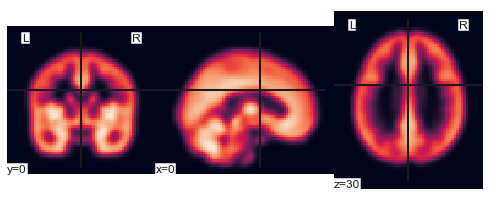

In [7]:
#brain nii and brain mask shape 
print("brain mask shape: ", brain_mask.shape)
print("brain_nii shape: ", brain_nii.shape) 

plotting.plot_img(brain_nii, cut_coords=[0, 0, 30]) #cut at 30th slice of z-coord



98508
(array([ 4,  4,  4, ..., 57, 57, 57]), array([27, 28, 28, ..., 34, 34, 34]), array([24, 22, 23, ..., 23, 24, 25]))


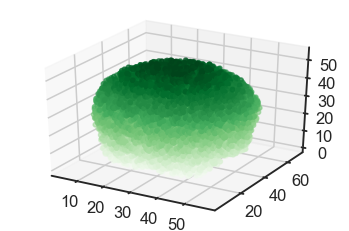

In [8]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
#3D plot of the voxels

print(len(coords[0])) #represents coordinates of each non-zero voxel (x, y, z)
#100,000 coords (many many voxels!)

print(coords)

fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = coords[2][0::10]
xdata = coords[0][0::10]
ydata = coords[1][0::10]

ax.scatter(xdata, ydata, zdata, c=zdata, cmap='Greens')


### 2.3 Compute ISC <a id="isc_compute"></a>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains.


In [9]:
# run ISC, loop over conditions 
isc_maps = {}
for task_name in all_task_names:
    isc_maps[task_name] = isc(bold[task_name], pairwise=False)
    print('Shape of %s condition:' % task_name, np.shape(isc_maps[task_name]))

Shape of word condition: (9, 98508)
Shape of intact1 condition: (12, 98508)


The output of ISC is a voxel by participant matrix (showing the result of each individual with the group). Below we will visualize the ISC matrix for one participant and condition back on to the brain to see where activity is correlated between participants.
This will take about 10 minutes to complete.

In [10]:
# set params 
subj_id = 0
task_name = 'intact1'
save_data = False

#for each task load in bold data of that task and compute ISC
#coords is shape 3 x 98508 

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
print(isc_vol.shape) #61 x 73 x 61, for one participant 

# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_maps[task_name][subj_id, :]

# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

# Save the ISC data as a volume
if save_data: 
    isc_map_path = os.path.join(dir_out, 'ISC_%s_sub%.2d.nii.gz' % (task_name, subj_id))
    nib.save(isc_nifti, isc_map_path)

(61, 73, 61)


#### Data from subject 0 plotted as a stat map against the average of all other subjects in intact condition. 

Text(0.5, 1.0, 'ISC map for subject 0, task = intact1')

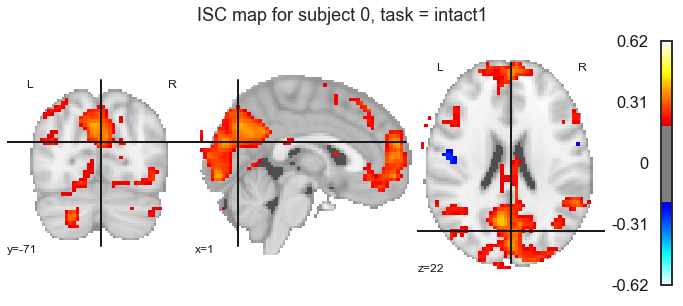

In [14]:
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title('ISC map for subject {}, task = {}' .format(subj_id,task_name)) 

Early information on where highest correlations may lie in ISC and ISFC. 

Make the averaged ISC map for the two conditions (intact, word-scrambled). Maps should be compared using the same xyz cut, threshold and vmax. 

In [15]:
print(all_task_names)
print(n_subjs) 

#word is scrambled, 9 total
task_name = 'word'
isc_vol_word = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
# use np.mean()

isc_vol_word[coords] = np.mean(isc_maps[task_name], axis = 0)
print(isc_vol_word.shape)
isc_nifti_word = nib.Nifti1Image(isc_vol_word, brain_nii.affine, brain_nii.header)

#intact1 is intact, 12 total 
task_name = 'intact1'
isc_vol_intact = np.zeros(brain_nii.shape)
isc_vol_intact[coords] = np.mean(isc_maps[task_name], axis = 0)
print(isc_vol_intact.shape)
isc_nifti_intact = nib.Nifti1Image(isc_vol_intact, brain_nii.affine, brain_nii.header)


['word', 'intact1']
{'word': 9, 'intact1': 12}
(61, 73, 61)
(61, 73, 61)


#### Scrambled Word Condition

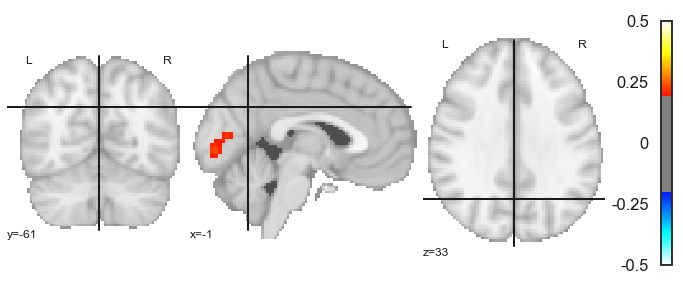

In [16]:
threshold = 0.2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti_word, 
    threshold=threshold, 
    axes=ax, 
    cut_coords = (-1, -61, 33)
)


#### Intact Condition

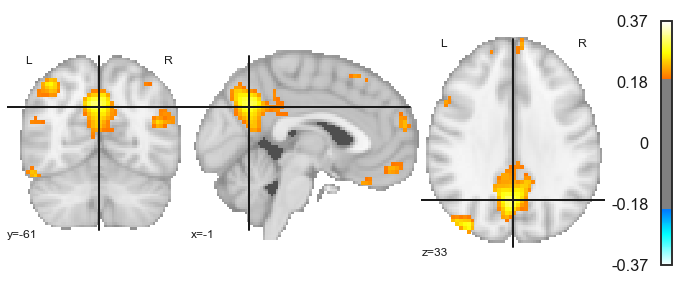

In [17]:
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    isc_nifti_intact, 
    threshold=threshold, 
    axes=ax,
    cut_coords = (-1, -61, 33)
)

**Explanation** 

The intact condition shows strong correlation with Wernicke's area commonly known for importance in language comprehension. Much lower correlations are seen with the scrambled word condition... early auditory areas are responsive regardless of the condition and higher level temporal structures became increasingly dependent on coherence. These higher level temporal structures may be specifically useful for foreign language learning for example.  

## 3. ISFC  <a id="isfc"></a>

The goal of ISFC is to find coupling between brain regions across participants. For example the angular gyrus in subject 1 could be correlated to the pre-frontal cortex in subject 2, if they share some cognitive state. For completely random cognitive states across these two subjects, the correlation should be zero. ISFC helps us identify such commonalities across subjects.

In this section, we will compare functional connectivity vs. ISFC on the Pieman data. Whereas functional connectivity is computed within individuals, ISFC is computed between individuals. Hence the only correlations that should be robust in ISFC are those that are present across individuals. This part of the notebook should illustrate that ISFC is sensitive to the cognitive state of the participants.

### 3.1 Parcel the Data  <a id="isfc_parcel"></a>

ISFC in voxel space is very computationally intensive, so for this notebook we will divide the brain into a smaller number of parcels. We are going to use predefined ROI masks to select the voxels.

number of voxels:	 (98508, 12)
number of parcels:	 96


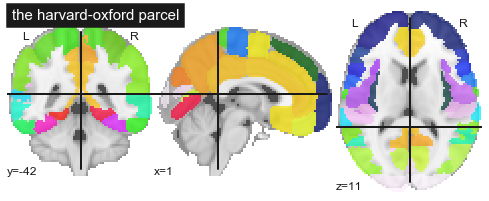

In [20]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split=True)
plotting.plot_roi(atlas.maps, title='the harvard-oxford parcel')

n_regions = len(atlas.labels)-1 # rm background region 
n_TRs = np.shape(bold[task_name])[0]

print('number of voxels:\t {}'.format(np.shape(bold[task_name][1])))
print('number of parcels:\t {}'.format(n_regions))

Convert the bold data into ROI parcels

In [21]:
# Get a masker for the atlas 
masker_ho = NiftiLabelsMasker(labels_img=atlas.maps)

# Transform the data to the parcel space
bold_ho = {
    task_name:np.zeros((n_TRs, n_regions, n_subjs[task_name])) 
    for task_name in all_task_names}

# Collect all data 
row_has_nan = np.zeros(shape=(n_regions,), dtype=bool)
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        
        # get the data for task t, subject s 
        nii_t_s = nib.load(fnames[task_name][subj_id])
        bold_ho[task_name][:,:,subj_id] = masker_ho.fit_transform(nii_t_s)
        
        # figure out missing rois
        row_has_nan_ = np.any(np.isnan(bold_ho[task_name][:,:,subj_id]),axis=0)
        row_has_nan[row_has_nan_] = True                

# Figure out which ROI has missing values
roi_select = np.logical_not(row_has_nan)
n_roi_select = np.sum(roi_select)
rois_filtered = np.array(atlas.labels[1:])[roi_select]
bold_ho_filtered = {
    task_name:np.zeros((n_TRs, n_roi_select, n_subjs[task_name])) 
    for task_name in all_task_names
}

# Remove ROIs with missing values
for task_name in all_task_names:
    for subj_id in range(n_subjs[task_name]):
        bold_ho_filtered[task_name][:,:,subj_id] = bold_ho[task_name][:,roi_select,subj_id]
              
print('ROI selected\n {}'.format(rois_filtered))
print('ROI removed due to missing values :( \n {}'.format(np.array(atlas.labels[1:])[row_has_nan]))

ROI selected
 ['Left Insular Cortex' 'Right Insular Cortex'
 'Left Inferior Frontal Gyrus, pars triangularis'
 'Right Inferior Frontal Gyrus, pars triangularis'
 'Left Inferior Frontal Gyrus, pars opercularis'
 'Right Inferior Frontal Gyrus, pars opercularis'
 'Left Superior Temporal Gyrus, anterior division'
 'Right Superior Temporal Gyrus, anterior division'
 'Left Superior Temporal Gyrus, posterior division'
 'Right Superior Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, anterior division'
 'Right Middle Temporal Gyrus, anterior division'
 'Left Middle Temporal Gyrus, posterior division'
 'Right Middle Temporal Gyrus, posterior division'
 'Left Middle Temporal Gyrus, temporooccipital part'
 'Right Middle Temporal Gyrus, temporooccipital part'
 'Right Inferior Temporal Gyrus, posterior division'
 'Left Inferior Temporal Gyrus, temporooccipital part'
 'Right Inferior Temporal Gyrus, temporooccipital part'
 'Left Supramarginal Gyrus, anterior division'
 'Right Supram

### 3.2 Compute FC and ISFC  <a id="fc_isfc"></a>


Compute FC on the parcellated data. 

In [23]:
fc_maps = {
    task_name:np.zeros((n_roi_select,n_roi_select)) 
    for task_name in all_task_names
}
for task_name in all_task_names: 
    for subj_id in range(n_subjs[task_name]): 
        fc_maps[task_name] += np.corrcoef(
            bold_ho_filtered[task_name][:,:,subj_id].T
        ) / n_subjs[task_name]
        np.fill_diagonal(fc_maps[task_name], np.nan)     

Compute ISFC on the parcellated data. 

In [24]:
isfc_maps_ho = {}
for task_name in all_task_names:
    isfc_maps_ho[task_name] = isfc(data=bold_ho_filtered[task_name],
                                   summary_statistic='median',
                                   vectorize_isfcs=False)   

#### Functional Connectivity Map, Intact Condition 

(65, 65)


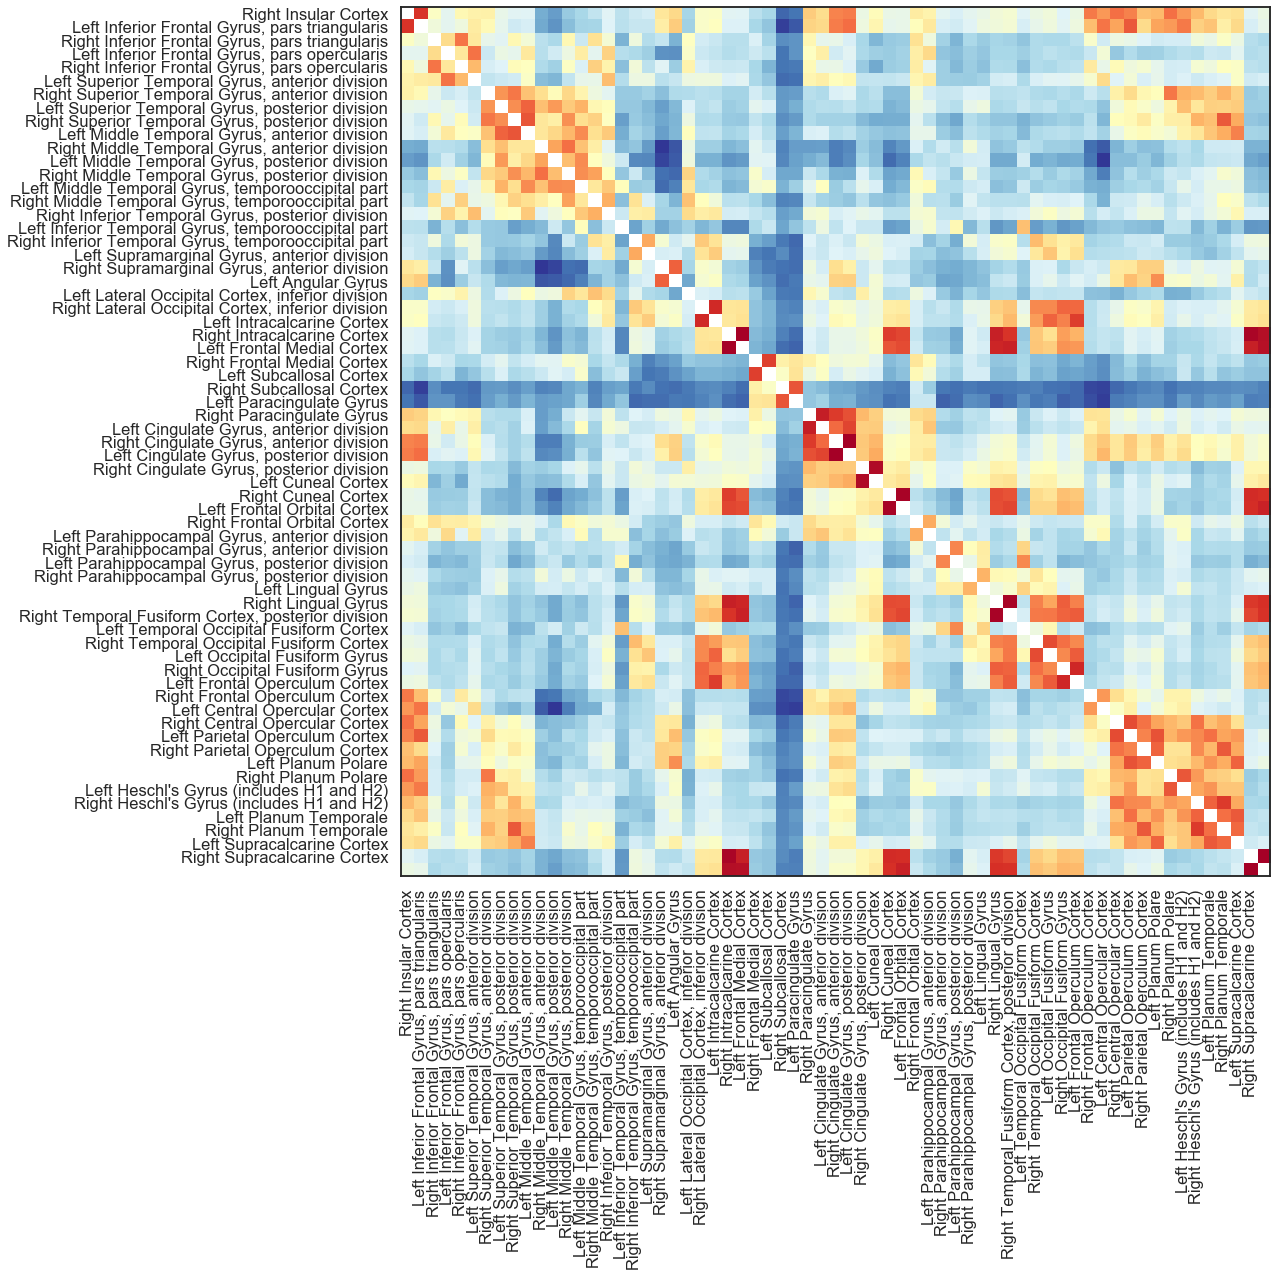

In [33]:
print(fc_maps['intact1'].shape)
labels = rois_filtered

fig = plt.figure(figsize=(22,16))

plt.imshow(fc_maps['intact1'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);



#### Connectome of Above Correlation Matrix

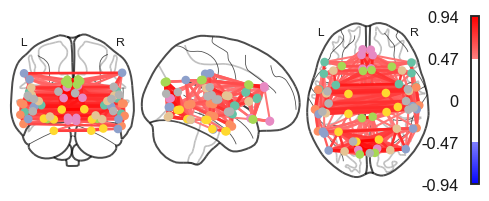

In [39]:
coords = plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]


plotting.plot_connectome(fc_maps['intact1'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

#### Functional Connectivity Map, Word Scrambled Condition 

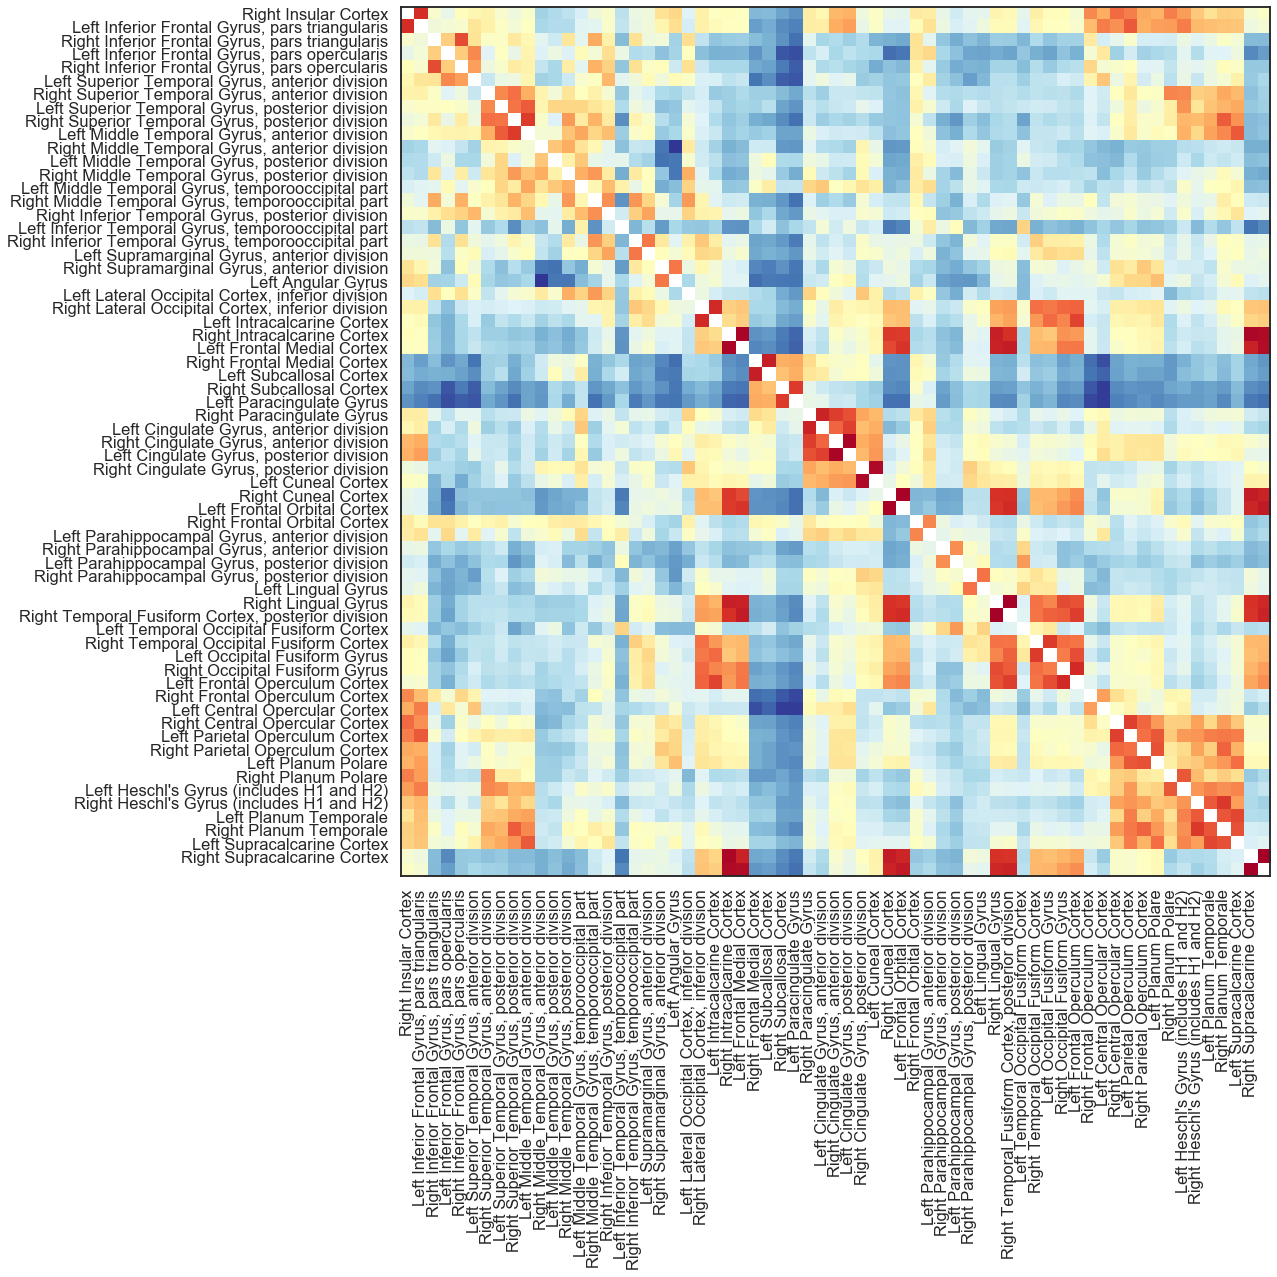

In [34]:
labels = rois_filtered

fig = plt.figure(figsize=(22,16))

plt.imshow(fc_maps['word'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


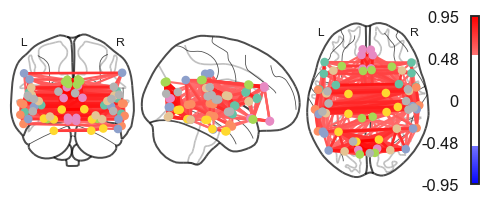

In [40]:
plotting.plot_connectome(fc_maps['word'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

#### Inter Subject Functional Connectivity Map, Intact Condition

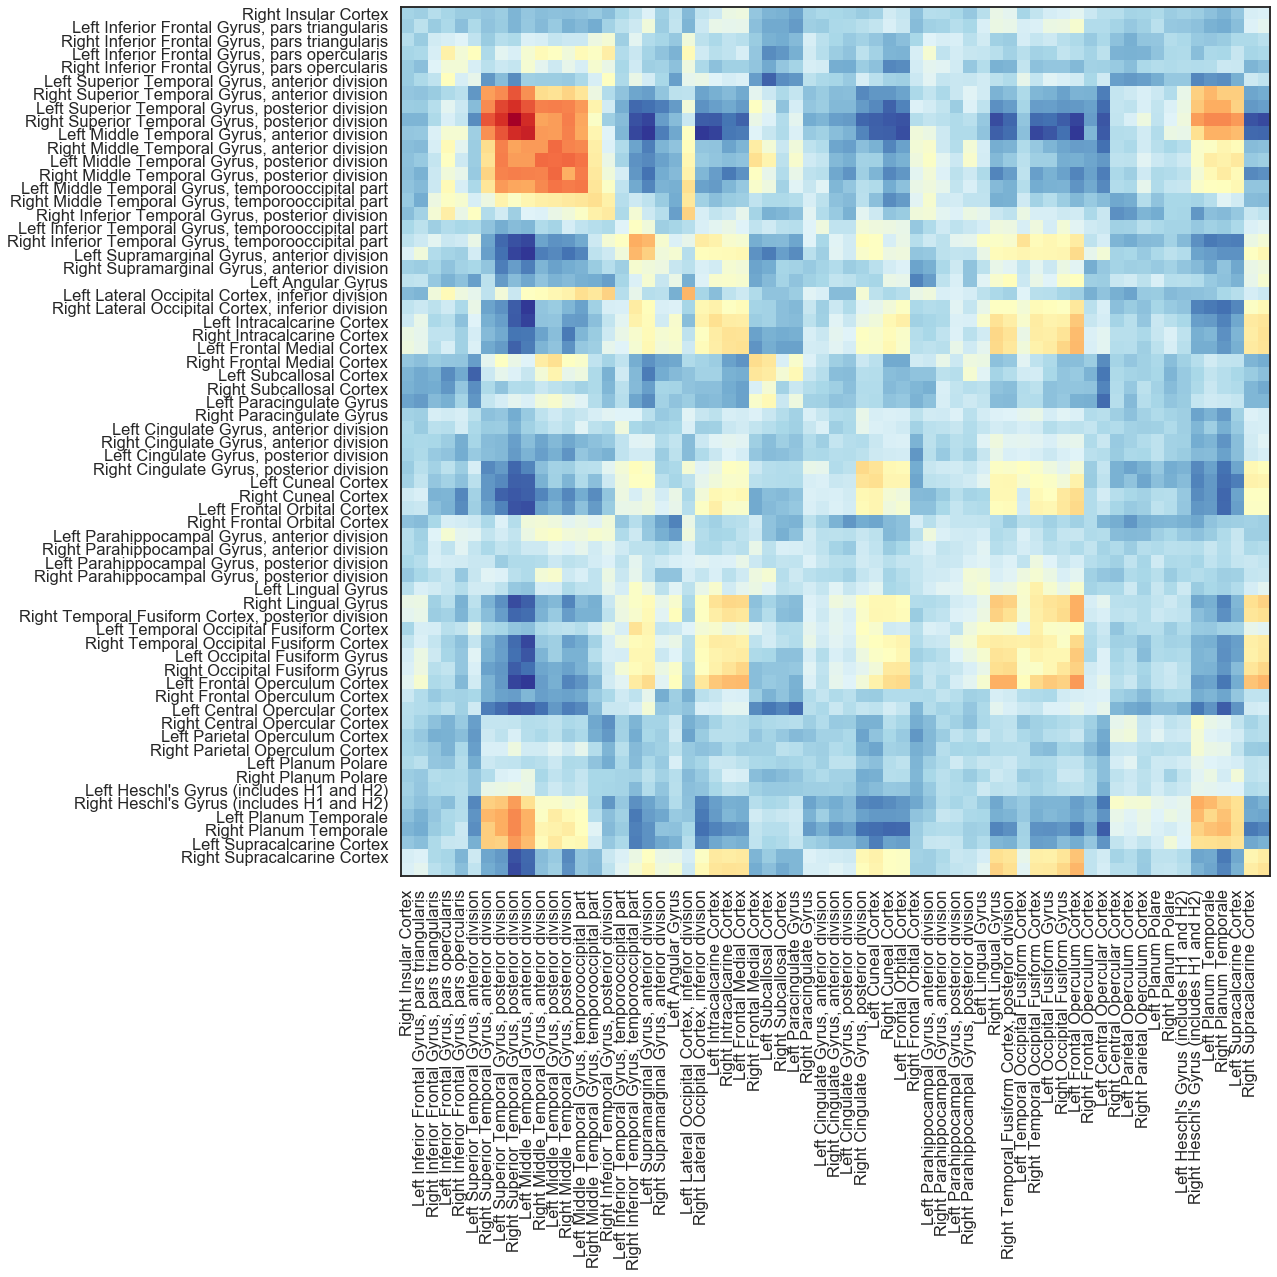

In [37]:
labels = rois_filtered

fig = plt.figure(figsize=(22,16))

plt.imshow(isfc_maps_ho['intact1'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


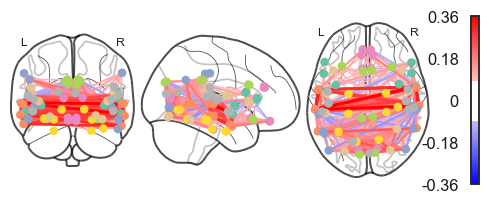

In [41]:
plotting.plot_connectome(isfc_maps_ho['intact1'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

#### Inter Subject Functional Connectivity Map, Word Scrambled Condition

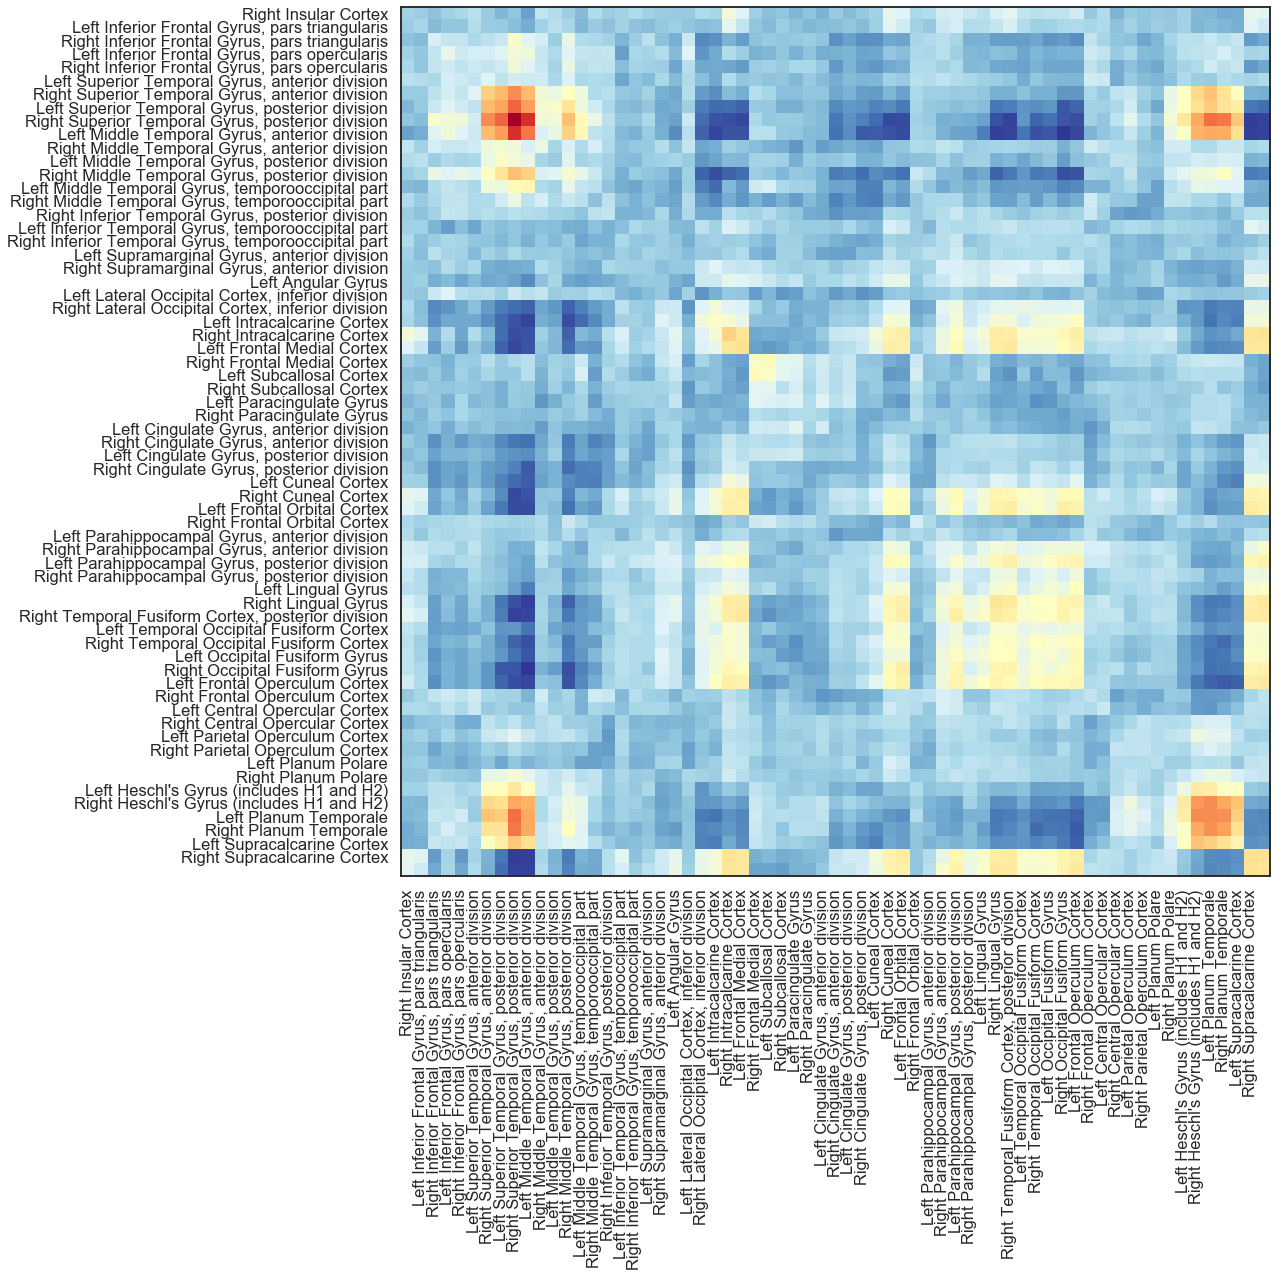

In [38]:
labels = rois_filtered

fig = plt.figure(figsize=(22,16))

plt.imshow(isfc_maps_ho['word'], cmap='RdYlBu_r')
plt.yticks(range(len(labels)), labels[1:]);
plt.xticks(range(len(labels)),labels[1:], rotation=90);


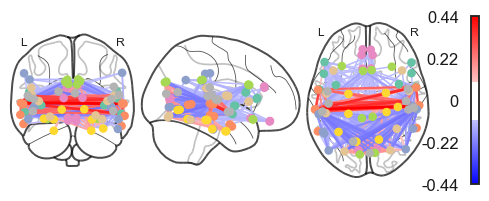

In [42]:
plotting.plot_connectome(isfc_maps_ho['word'], coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

The plot_connectome function takes as an input a correlation matrix (such as the FC one plotted above) and also a set of coordinates that define the XYZ coordinates that corresponds to each column/row of the correlation matrix. In order to get the coordinates of these ROIs, we recommend you use: `plotting.find_parcellation_cut_coords(atlas.maps)[roi_select]`  

**Explanation**

The correlations that exist in the FC map connectomes are high because the correlations are being computed within individuals rather than between. ISFC on the other hand shows the characteristic correlations that exist across subjects. 

For this reason ISFC maps show more negative correlations. This result is even more pronounced for the word condition than the intact condition likely because people's neural reactions are not all the same when presented with confusing, seemingly random sequences of words. 

It is interesting to note the cross hemisphere correlations that are always present in the midbrain of the ISFC connectomes, which are likely representative of low level auditory processing.  


## Conclusion <a id="conclusion"></a>

ISC indicates the correlation of one subject’s voxel with the average of that voxel in all other subjects (one voxel:same voxel). ISFC allows identification of coupling between non-aligned voxels (one voxel:other voxel).

This notebook examines which voxels are responding preferentially to a story vs a random assortment of words. This notebook illustrated the possibility to distinguish between active and non active conditions by performing full brain analysis as opposed to seed based analysis. 

Section 2.3 illustrates plots of the brain following ISC. It shows significant neural activity in several brain regions as well as some negative correlates when listening to a narrative story. The scrambled condition on the other hand shows only small activity in wernicke’s area (responsible for language comprehension). 

ISFC is a little more descriptive and shows some areas of clear positive and negative correlation that are further visualized in the connectome plots. One area of high activity is the superior temporal gyrus also know as the auditory association cortex. There are far more negative correlations in the scrambled word condition than the intact condition as explained above. 

This notebook as a whole highlights the differences between and use cases of inter-subject correlation, inter-subject functional correlation, and functional connectivity. 

### Contributions<a id="contributions"></a>

E. Simony and U. Hasson for providing data  
C. Baldassano and C. Chen provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
S. Nastase enhanced the ISC brainiak module; added the section on statistical testing   
Q. Lu added solutions; switched to S. Nastase's ISC module; replicated Lerner et al 2011 & Simony et al. 2016; added spatial ISC.   
M. Kumar edits to section introductions and explanation on permutation test.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19  